In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import torch

sys.path.append('..')
from src.utils import *
from src.models import *
from src.configs import *


from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
rcParams.update(fig_params)

import warnings

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

## Set device

In [2]:
DEVICE = 'cuda:2' if torch.cuda.is_available() else 'cpu'
print('Using device:', DEVICE)

Using device: cuda:2


## Load experiments file

In [3]:
FILENAME = 'Experiments_MASSIVE.xlsx'

In [4]:
exp_df = pd.read_excel(os.path.join('..', 'experiments', FILENAME), dtype=FORMAT)
exp_df.head()

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
0,MASSIVE000,8925,64,1000,100,20,0.5,5,1.0,300,350.0
1,MASSIVE001,65459,64,1000,100,20,0.5,5,1.0,300,350.0
2,MASSIVE002,30300,64,1000,100,20,0.5,5,1.0,300,350.0
3,MASSIVE003,38747,64,1000,100,20,0.5,5,1.0,300,350.0
4,MASSIVE004,26932,64,1000,100,20,0.5,5,1.0,300,350.0


## Run experiments

In [5]:
exp_df = exp_df.iloc[130:].copy()
exp_df

,exp_id,seed,torch_dtype,samples_number,features_number,snr_db,informative_frac,folds_number,initialization,epochs_number,learning_rate
130,MASSIVE130,62496,64,1000,1400,20,0.5,5,1.0,300,350.0
131,MASSIVE131,17063,64,1000,1400,20,0.5,5,1.0,300,350.0
132,MASSIVE132,58235,64,1000,1400,20,0.5,5,1.0,300,350.0
133,MASSIVE133,86544,64,1000,1400,20,0.5,5,1.0,300,350.0
134,MASSIVE134,30268,64,1000,1400,20,0.5,5,1.0,300,350.0
135,MASSIVE135,4312,64,1000,1400,20,0.5,5,1.0,300,350.0
136,MASSIVE136,84564,64,1000,1400,20,0.5,5,1.0,300,350.0
137,MASSIVE137,76526,64,1000,1400,20,0.5,5,1.0,300,350.0
138,MASSIVE138,54059,64,1000,1400,20,0.5,5,1.0,300,350.0
139,MASSIVE139,79857,64,1000,1400,20,0.5,5,1.0,300,350.0


In [7]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

for i, exp in exp_df.iterrows():
    EXP_ID = exp.exp_id
    SEED = exp.seed
    if exp.torch_dtype == 64:
        DTYPE = torch.float64
    elif exp.torch_dtype == 32:
        DTYPE = torch.float32
    N = exp.samples_number
    D = exp.features_number
    SNR_DB = exp.snr_db
    INFORMATIVE_FRAC = exp.informative_frac
    NUM_FOLDS = exp.folds_number
    INITIALIZATION = exp.initialization
    EPOCHS = exp.epochs_number
    LEARNING_RATE = exp.learning_rate
    
    ### Create output folders
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data'), exist_ok=True)
    data_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'data')
    os.makedirs(os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images'), exist_ok=True)
    images_folder = os.path.join('..', 'results', 'multiridge', FILENAME.split('.')[0], 'images')
    
    ### Data generation
    train, test, features, target, theta_true = generate_synthetic_dataset(n_samples_train=N, n_samples_test=100000, n_features=D, n_informative=int(D*INFORMATIVE_FRAC),
                                                                           snr_db=SNR_DB, random_state=SEED)
    check_snr(train, test, features, target, theta_true, snr_db=SNR_DB)

    ### MultiRidge optimization
    initialization = np.ones(D)*exp.initialization
    learning_rate = LinearLR(initial_lr=LEARNING_RATE, decay=0.999)
    model = MultiRidge(lambda_vector=initialization, folds=NUM_FOLDS, shuffle=True, random_state=SEED, normalize=True, epochs=EPOCHS, learning_rate=learning_rate,
                       scoring={'r2': r2_score, 'mse': mean_squared_error}, verbose=1, device=DEVICE, dtype=DTYPE)
    model.fit(train[features], train[target], eval_set=(test[features], test[target]))
    results_dict = {'exp_id': EXP_ID, 'history_df': model.history_df}#, 'history_coef': history_coef}
    with open(os.path.join(data_folder, f'{EXP_ID}.pickle'), 'wb') as handle:
        pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    model.history_df[['mean_train_r2', 'mean_valid_r2', 'test_r2_refit', 'train_r2_refit']].plot()
    plt.ylim(0.0, 1.0)
    pathfile_mr = os.path.join(images_folder, f'{EXP_ID}')
    plt.savefig(pathfile_mr, dpi = 200)
    plt.close()

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.874, Valid r2: 0.383, Test r2: 0.488, Train mse: 0.126, Valid mse: 0.617, Test mse: 0.509
Epoch 2: Train r2: 0.936, Valid r2: 0.662, Test r2: 0.557, Train mse: 0.064, Valid mse: 0.335, Test mse: 0.441
Epoch 3: Train r2: 0.958, Valid r2: 0.735, Test r2: 0.592, Train mse: 0.042, Valid mse: 0.266, Test mse: 0.406
Epoch 4: Train r2: 0.968, Valid r2: 0.774, Test r2: 0.612, Train mse: 0.032, Valid mse: 0.225, Test mse: 0.386
Epoch 5: Train r2: 0.971, Valid r2: 0.800, Test r2: 0.622, Train mse: 0.029, Valid mse: 0.199, Test mse: 0.376
Epoch 6: Train r2: 0.975, Valid r2: 0.812, Test r2: 0.628, Train mse: 0.025, Valid mse: 0.189, Test mse: 0.370
Epoch 7: Train r2: 0.978, Valid r2: 0.824, Test r2: 0.653, Train mse: 0.022, Valid mse: 0.176, Test mse: 0.346
Epoch 8: Train r2: 0.980, Valid r2: 0.833, Test r2: 0.660, Train mse: 0.020, Valid mse: 0.164, Test mse: 0.338
Epoch 9: Train r2: 0.983, Valid r2: 0.855, Test r2: 0.659, Train mse: 0.017, Valid mse: 0.145, Test mse: 0.339
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.886, Valid r2: 0.446, Test r2: 0.484, Train mse: 0.114, Valid mse: 0.558, Test mse: 0.496
Epoch 2: Train r2: 0.947, Valid r2: 0.689, Test r2: 0.536, Train mse: 0.053, Valid mse: 0.310, Test mse: 0.445
Epoch 3: Train r2: 0.963, Valid r2: 0.768, Test r2: 0.561, Train mse: 0.037, Valid mse: 0.229, Test mse: 0.422
Epoch 4: Train r2: 0.971, Valid r2: 0.803, Test r2: 0.596, Train mse: 0.029, Valid mse: 0.194, Test mse: 0.388
Epoch 5: Train r2: 0.975, Valid r2: 0.820, Test r2: 0.618, Train mse: 0.025, Valid mse: 0.179, Test mse: 0.367
Epoch 6: Train r2: 0.977, Valid r2: 0.834, Test r2: 0.622, Train mse: 0.023, Valid mse: 0.164, Test mse: 0.363
Epoch 7: Train r2: 0.980, Valid r2: 0.843, Test r2: 0.639, Train mse: 0.020, Valid mse: 0.157, Test mse: 0.347
Epoch 8: Train r2: 0.981, Valid r2: 0.848, Test r2: 0.657, Train mse: 0.019, Valid mse: 0.151, Test mse: 0.330
Epoch 9: Train r2: 0.981, Valid r2: 0.845, Test r2: 0.654, Train mse: 0.019, Valid mse: 0.155, Test mse: 0.333
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.887, Valid r2: 0.431, Test r2: 0.451, Train mse: 0.113, Valid mse: 0.569, Test mse: 0.559
Epoch 2: Train r2: 0.943, Valid r2: 0.676, Test r2: 0.524, Train mse: 0.057, Valid mse: 0.322, Test mse: 0.485
Epoch 3: Train r2: 0.960, Valid r2: 0.750, Test r2: 0.583, Train mse: 0.040, Valid mse: 0.248, Test mse: 0.424
Epoch 4: Train r2: 0.969, Valid r2: 0.787, Test r2: 0.599, Train mse: 0.031, Valid mse: 0.210, Test mse: 0.408
Epoch 5: Train r2: 0.977, Valid r2: 0.829, Test r2: 0.623, Train mse: 0.023, Valid mse: 0.170, Test mse: 0.384
Epoch 6: Train r2: 0.980, Valid r2: 0.844, Test r2: 0.635, Train mse: 0.020, Valid mse: 0.156, Test mse: 0.372
Epoch 7: Train r2: 0.980, Valid r2: 0.828, Test r2: 0.654, Train mse: 0.020, Valid mse: 0.171, Test mse: 0.353
Epoch 8: Train r2: 0.982, Valid r2: 0.841, Test r2: 0.663, Train mse: 0.018, Valid mse: 0.159, Test mse: 0.343
Epoch 9: Train r2: 0.980, Valid r2: 0.828, Test r2: 0.677, Train mse: 0.020, Valid mse: 0.171, Test mse: 0.329
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.886, Valid r2: 0.428, Test r2: 0.504, Train mse: 0.114, Valid mse: 0.574, Test mse: 0.462
Epoch 2: Train r2: 0.948, Valid r2: 0.689, Test r2: 0.594, Train mse: 0.052, Valid mse: 0.311, Test mse: 0.378
Epoch 3: Train r2: 0.967, Valid r2: 0.787, Test r2: 0.646, Train mse: 0.033, Valid mse: 0.213, Test mse: 0.330
Epoch 4: Train r2: 0.974, Valid r2: 0.816, Test r2: 0.680, Train mse: 0.026, Valid mse: 0.184, Test mse: 0.298
Epoch 5: Train r2: 0.978, Valid r2: 0.835, Test r2: 0.707, Train mse: 0.022, Valid mse: 0.164, Test mse: 0.273
Epoch 6: Train r2: 0.982, Valid r2: 0.847, Test r2: 0.726, Train mse: 0.018, Valid mse: 0.152, Test mse: 0.255
Epoch 7: Train r2: 0.982, Valid r2: 0.842, Test r2: 0.743, Train mse: 0.018, Valid mse: 0.157, Test mse: 0.240
Epoch 8: Train r2: 0.983, Valid r2: 0.853, Test r2: 0.753, Train mse: 0.017, Valid mse: 0.147, Test mse: 0.230
Epoch 9: Train r2: 0.985, Valid r2: 0.867, Test r2: 0.758, Train mse: 0.015, Valid mse: 0.133, Test mse: 0.226
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.883, Valid r2: 0.447, Test r2: 0.470, Train mse: 0.117, Valid mse: 0.553, Test mse: 0.530
Epoch 2: Train r2: 0.940, Valid r2: 0.655, Test r2: 0.544, Train mse: 0.060, Valid mse: 0.343, Test mse: 0.456
Epoch 3: Train r2: 0.962, Valid r2: 0.770, Test r2: 0.589, Train mse: 0.038, Valid mse: 0.232, Test mse: 0.411
Epoch 4: Train r2: 0.972, Valid r2: 0.807, Test r2: 0.618, Train mse: 0.028, Valid mse: 0.193, Test mse: 0.382
Epoch 5: Train r2: 0.975, Valid r2: 0.821, Test r2: 0.626, Train mse: 0.025, Valid mse: 0.177, Test mse: 0.375
Epoch 6: Train r2: 0.980, Valid r2: 0.840, Test r2: 0.626, Train mse: 0.020, Valid mse: 0.160, Test mse: 0.374
Epoch 7: Train r2: 0.979, Valid r2: 0.828, Test r2: 0.626, Train mse: 0.021, Valid mse: 0.170, Test mse: 0.375
Epoch 8: Train r2: 0.979, Valid r2: 0.831, Test r2: 0.641, Train mse: 0.021, Valid mse: 0.168, Test mse: 0.359
Epoch 9: Train r2: 0.980, Valid r2: 0.848, Test r2: 0.649, Train mse: 0.020, Valid mse: 0.151, Test mse: 0.351
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.878, Valid r2: 0.428, Test r2: 0.471, Train mse: 0.122, Valid mse: 0.570, Test mse: 0.540
Epoch 2: Train r2: 0.939, Valid r2: 0.666, Test r2: 0.529, Train mse: 0.061, Valid mse: 0.332, Test mse: 0.480
Epoch 3: Train r2: 0.958, Valid r2: 0.743, Test r2: 0.582, Train mse: 0.042, Valid mse: 0.254, Test mse: 0.427
Epoch 4: Train r2: 0.968, Valid r2: 0.780, Test r2: 0.619, Train mse: 0.032, Valid mse: 0.216, Test mse: 0.389
Epoch 5: Train r2: 0.974, Valid r2: 0.822, Test r2: 0.641, Train mse: 0.026, Valid mse: 0.177, Test mse: 0.367
Epoch 6: Train r2: 0.977, Valid r2: 0.822, Test r2: 0.659, Train mse: 0.023, Valid mse: 0.177, Test mse: 0.349
Epoch 7: Train r2: 0.978, Valid r2: 0.819, Test r2: 0.674, Train mse: 0.022, Valid mse: 0.180, Test mse: 0.333
Epoch 8: Train r2: 0.979, Valid r2: 0.827, Test r2: 0.684, Train mse: 0.021, Valid mse: 0.172, Test mse: 0.323
Epoch 9: Train r2: 0.979, Valid r2: 0.823, Test r2: 0.678, Train mse: 0.021, Valid mse: 0.176, Test mse: 0.329
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.878, Valid r2: 0.387, Test r2: 0.481, Train mse: 0.122, Valid mse: 0.612, Test mse: 0.529
Epoch 2: Train r2: 0.940, Valid r2: 0.661, Test r2: 0.542, Train mse: 0.060, Valid mse: 0.336, Test mse: 0.466
Epoch 3: Train r2: 0.956, Valid r2: 0.734, Test r2: 0.571, Train mse: 0.044, Valid mse: 0.267, Test mse: 0.437
Epoch 4: Train r2: 0.965, Valid r2: 0.771, Test r2: 0.591, Train mse: 0.035, Valid mse: 0.228, Test mse: 0.416
Epoch 5: Train r2: 0.972, Valid r2: 0.796, Test r2: 0.607, Train mse: 0.028, Valid mse: 0.203, Test mse: 0.400
Epoch 6: Train r2: 0.974, Valid r2: 0.793, Test r2: 0.611, Train mse: 0.026, Valid mse: 0.204, Test mse: 0.396
Epoch 7: Train r2: 0.976, Valid r2: 0.817, Test r2: 0.617, Train mse: 0.024, Valid mse: 0.182, Test mse: 0.390
Epoch 8: Train r2: 0.978, Valid r2: 0.824, Test r2: 0.636, Train mse: 0.022, Valid mse: 0.174, Test mse: 0.371
Epoch 9: Train r2: 0.980, Valid r2: 0.825, Test r2: 0.658, Train mse: 0.020, Valid mse: 0.172, Test mse: 0.348
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.874, Valid r2: 0.402, Test r2: 0.479, Train mse: 0.126, Valid mse: 0.595, Test mse: 0.534
Epoch 2: Train r2: 0.941, Valid r2: 0.662, Test r2: 0.543, Train mse: 0.059, Valid mse: 0.338, Test mse: 0.468
Epoch 3: Train r2: 0.959, Valid r2: 0.747, Test r2: 0.587, Train mse: 0.041, Valid mse: 0.254, Test mse: 0.423
Epoch 4: Train r2: 0.966, Valid r2: 0.772, Test r2: 0.609, Train mse: 0.034, Valid mse: 0.227, Test mse: 0.401
Epoch 5: Train r2: 0.973, Valid r2: 0.800, Test r2: 0.632, Train mse: 0.027, Valid mse: 0.199, Test mse: 0.377
Epoch 6: Train r2: 0.976, Valid r2: 0.819, Test r2: 0.650, Train mse: 0.024, Valid mse: 0.180, Test mse: 0.359
Epoch 7: Train r2: 0.979, Valid r2: 0.830, Test r2: 0.661, Train mse: 0.021, Valid mse: 0.169, Test mse: 0.348
Epoch 8: Train r2: 0.979, Valid r2: 0.821, Test r2: 0.673, Train mse: 0.021, Valid mse: 0.179, Test mse: 0.335
Epoch 9: Train r2: 0.981, Valid r2: 0.829, Test r2: 0.693, Train mse: 0.019, Valid mse: 0.171, Test mse: 0.315
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.883, Valid r2: 0.421, Test r2: 0.502, Train mse: 0.117, Valid mse: 0.579, Test mse: 0.465
Epoch 2: Train r2: 0.945, Valid r2: 0.691, Test r2: 0.568, Train mse: 0.055, Valid mse: 0.305, Test mse: 0.404
Epoch 3: Train r2: 0.964, Valid r2: 0.761, Test r2: 0.593, Train mse: 0.036, Valid mse: 0.237, Test mse: 0.380
Epoch 4: Train r2: 0.970, Valid r2: 0.802, Test r2: 0.616, Train mse: 0.030, Valid mse: 0.198, Test mse: 0.359
Epoch 5: Train r2: 0.976, Valid r2: 0.818, Test r2: 0.633, Train mse: 0.024, Valid mse: 0.179, Test mse: 0.343
Epoch 6: Train r2: 0.979, Valid r2: 0.831, Test r2: 0.645, Train mse: 0.021, Valid mse: 0.168, Test mse: 0.331
Epoch 7: Train r2: 0.978, Valid r2: 0.832, Test r2: 0.642, Train mse: 0.022, Valid mse: 0.167, Test mse: 0.334
Epoch 8: Train r2: 0.982, Valid r2: 0.845, Test r2: 0.660, Train mse: 0.018, Valid mse: 0.153, Test mse: 0.318
Epoch 9: Train r2: 0.981, Valid r2: 0.832, Test r2: 0.666, Train mse: 0.019, Valid mse: 0.166, Test mse: 0.312
E

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.879, Valid r2: 0.431, Test r2: 0.466, Train mse: 0.121, Valid mse: 0.568, Test mse: 0.544
Epoch 2: Train r2: 0.939, Valid r2: 0.651, Test r2: 0.548, Train mse: 0.061, Valid mse: 0.346, Test mse: 0.460
Epoch 3: Train r2: 0.959, Valid r2: 0.739, Test r2: 0.592, Train mse: 0.041, Valid mse: 0.261, Test mse: 0.416
Epoch 4: Train r2: 0.966, Valid r2: 0.764, Test r2: 0.619, Train mse: 0.034, Valid mse: 0.234, Test mse: 0.388
Epoch 5: Train r2: 0.972, Valid r2: 0.794, Test r2: 0.628, Train mse: 0.028, Valid mse: 0.205, Test mse: 0.379
Epoch 6: Train r2: 0.975, Valid r2: 0.805, Test r2: 0.630, Train mse: 0.025, Valid mse: 0.192, Test mse: 0.377
Epoch 7: Train r2: 0.978, Valid r2: 0.828, Test r2: 0.645, Train mse: 0.022, Valid mse: 0.170, Test mse: 0.362
Epoch 8: Train r2: 0.980, Valid r2: 0.843, Test r2: 0.668, Train mse: 0.020, Valid mse: 0.157, Test mse: 0.339
Epoch 9: Train r2: 0.982, Valid r2: 0.852, Test r2: 0.686, Train mse: 0.018, Valid mse: 0.147, Test mse: 0.320
E

In [25]:
### MultiRidge optimization
initialization = np.ones(D)*exp.initialization
lr_scheduler = LinearLR(initial_lr=LEARNING_RATE, decay=0.999)
model = MultiRidge2(lambda_vector=initialization, folds=NUM_FOLDS, shuffle=True, random_state=SEED, normalize=True, epochs=10, learning_rate=lr_scheduler,
                   scoring={'r2': r2_score, 'mse': mean_squared_error}, 
                    verbose=1, device=DEVICE, dtype=DTYPE)
model.fit(train[features], train[target], eval_set=(test[features], test[target]))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: Train r2: 0.852, Valid r2: 0.472, Test r2: 0.532, Train mse: 0.148, Valid mse: 0.529, Test mse: 0.472
Epoch 2: Train r2: 0.934, Valid r2: 0.733, Test r2: 0.651, Train mse: 0.066, Valid mse: 0.264, Test mse: 0.352
Epoch 3: Train r2: 0.959, Valid r2: 0.795, Test r2: 0.718, Train mse: 0.041, Valid mse: 0.205, Test mse: 0.285
Epoch 4: Train r2: 0.971, Valid r2: 0.848, Test r2: 0.767, Train mse: 0.029, Valid mse: 0.149, Test mse: 0.235
Epoch 5: Train r2: 0.976, Valid r2: 0.864, Test r2: 0.798, Train mse: 0.024, Valid mse: 0.136, Test mse: 0.204
Epoch 6: Train r2: 0.980, Valid r2: 0.885, Test r2: 0.829, Train mse: 0.020, Valid mse: 0.113, Test mse: 0.173
Epoch 7: Train r2: 0.982, Valid r2: 0.882, Test r2: 0.855, Train mse: 0.018, Valid mse: 0.116, Test mse: 0.146
Epoch 8: Train r2: 0.985, Valid r2: 0.910, Test r2: 0.873, Train mse: 0.015, Valid mse: 0.090, Test mse: 0.128
Epoch 9: Train r2: 0.985, Valid r2: 0.900, Test r2: 0.874, Train mse: 0.015, Valid mse: 0.099, Test mse: 0.127
E

MultiRidge2(device='cuda:2', dtype=torch.float64, epochs=10,
            lambda_vector=tensor([ 1.1815, -0.0143,  1.1165,  ...,  1.1918,  0.1984,  0.9979],
       device='cuda:2', dtype=torch.float64),
            learning_rate=<src.models.LinearLR object at 0x7f6edf138220>,
            random_state=47464,
            scoring={'mse': <function mean_squared_error at 0x7f6f704b6a60>,
                     'r2': <function r2_score at 0x7f6f704b6f70>},
            verbose=1)

(0.0, 1.0)

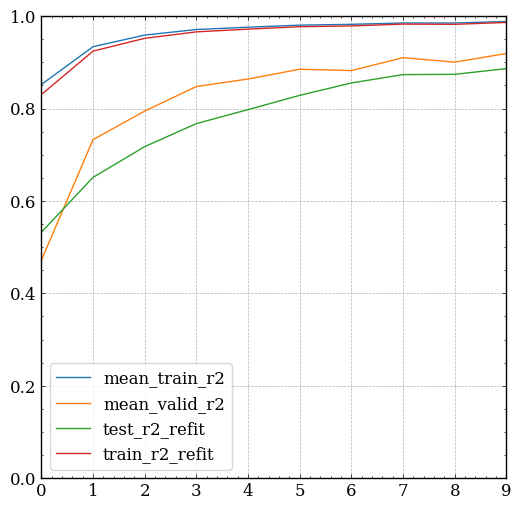

In [57]:
model.history_df[['mean_train_r2', 'mean_valid_r2', 'test_r2_refit', 'train_r2_refit']].plot()
plt.ylim(0.0, 1.0)

In [58]:
model.coef_

array([  1.87296466, -40.51134348,  -2.50760956, ...,  -1.05739057,
       -24.857464  ,   2.89565897])

In [60]:
fig_params = {'train_color': "#9fc377", 'test_color': "#0272a2", 'valid_color': "#ca0b03"}
metric_params = {'metric': 'r2', 'metric_func': r2_score, 'metric_label': '$R^2$'}

r2_score(test[target].values, model.predict(test[features]))

0.886556790194081

In [47]:
model.scaler_y.var_

array([475214.17821939])

In [ ]:
def plot_diagnostics(train,
                     test,
                     features,
                     target,
                     model,
                     model_name,
                     gs,
                     axes_idx,
                     fig_params,
                     metric_params,
                     share_axes=None):
    
    metric = metric_params['metric']
    metric_func = metric_params['metric_func']
    metric_label = metric_params['metric_label']
    train_color = fig_params['train_color']
    test_color = fig_params['test_color']
    if share_axes is not None:
        ax0 = plt.subplot(gs[axes_idx[0]], sharex=share_axes[0], sharey=share_axes[0])
    else:
        ax0 = plt.subplot(gs[axes_idx[0]])
    test_actual = test[target].values
    test_preds = model.predict(test[features])
    train_actual = train[target].values
    train_preds = model.predict(train[features])
    ax0.scatter(test_preds, test_actual, alpha=0.2, c=test_color, label='Test {}$= {:0.3f}$'.format(metric_label, metric_func(test_actual, test_preds)))
    ax0.scatter(train_preds, train_actual, alpha=0.6, c=train_color, label='Train {}$= {:0.3f}$'.format(metric_label, metric_func(train_actual, train_preds)))
    # ## Make square
    # ylim = ax0.get_ylim()
    # xlim = ax0.get_xlim()
    # bounds = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
    # ax0.set_xlim(bounds)
    # ax0.set_ylim(bounds)
    # ax0.set_aspect('equal', adjustable='box')
    ## Draw identity line
    # ax0.plot(bounds, bounds, lw=2, ls='--', color='k', alpha=0.5)
    ax0.set_xlabel(r"$\hat{y}$")
    ax0.set_ylabel(r"$y$")
    # ax0.set_xticks(ax0.get_yticks())
    # for label in ax0.get_xticklabels():
    #     label.set_rotation(45)
    #     label.set_ha('right')
    leg = ax0.legend(loc='best', frameon=True)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    ax0.set_title(f'{model_name} prediction plot')
    
    if share_axes is not None:
        ax1 = plt.subplot(gs[axes_idx[1]], sharex=share_axes[1], sharey=share_axes[1])
    else:
        ax1 = plt.subplot(gs[axes_idx[1]])
    test_residual = test_actual - test_preds
    train_residual = train_actual - train_preds
    ax1.scatter(test_preds, test_residual, alpha=0.2, c=test_color, label='Test {}$= {:0.3f}$'.format(metric_label, metric_func(test_actual, test_preds)))
    ax1.scatter(train_preds, train_residual, alpha=0.6, c=train_color, label='Train {}$= {:0.3f}$'.format(metric_label, metric_func(train_actual, train_preds)))
    #ax1.axhline(y=0, lw=2, ls='--', color='k', alpha=0.5)
    #ax1.set_aspect('equal', adjustable='box')
    ax1.set_xlabel(r"$\hat{y}$")
    ax1.set_ylabel(r"$y - \hat{y}$")
    leg = ax1.legend(loc='best', frameon=True)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    divider = make_axes_locatable(ax1)
    hax = divider.append_axes("right", size=1, pad=0.1, sharey=ax1)
    hax.yaxis.tick_right()
    hax.grid(False, axis="x")
    hax.hist(test_residual, bins=50, orientation="horizontal", density=True, color=test_color)
    hax.hist(train_residual, bins=50, orientation="horizontal", density=True, color=train_color)
    ax1.set_title(f'{model_name} residual plot')
    
    return (ax0, ax1)